In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import pandas as pd
from shapely import Polygon
import math

In [2]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_processed.nc")
#ds=ds.set_coords(("lon_rho","lat_rho"))
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 73, bnds: 2, s_rho: 31, s_w: 32, tracer: 2,
                      boundary: 4, Nuser: 1, eta_rho: 600, xi_rho: 800,
                      xi_u: 799, eta_v: 599)
Coordinates:
  * ocean_time       (ocean_time) datetime64[ns] 2025-12-30 ... 2026-12-25
  * s_rho            (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w              (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    lat_rho          (eta_rho, xi_rho) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0           (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: bnds, tracer, boundary, Nuser, eta_rho, xi_rho,
                                xi_u, eta_v
Data variables: (12/51)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    z_u              (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    z_v              (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dx               (eta_rho, xi_rho) float64 ...
    dy               (eta_rho, xi_rho) float64 ...
    dz               (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    dA               (eta_rho, xi_rho) float64 ...
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [3]:
ds['hc']=20
def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])



    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

        # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

ds = processROMSGrid(ds)

grid = makeROMSGridObject(ds)

In [4]:
#Find area of polygon
def PolyArea(x,y,eta_ind):
    dx= x*np.asarray((111132.954 * np.cos((math.pi/180*ds.lat_rho.isel(eta_rho=eta_ind)[1].values))))
    return 0.5*np.abs(np.dot(dx,np.roll(y,1))-np.dot(y,np.roll(dx,1)))*1e-6

#print(PolyArea(x,y,eta_ind))
#print(Polygon(coords).centroid)
#print(min(y))

IndexError: list index out of range

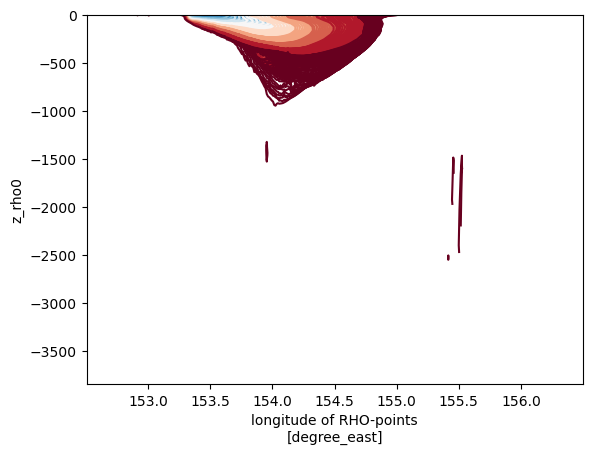

In [5]:
eac_contour=pd.DataFrame(columns=['eta_index','lon','centre_depth','max_depth','area'])

for eta_ind in range(5,595,5):
    
    
    cs=xr.plot.contour(ds.v_northward.isel(eta_rho=eta_ind,xi_rho=slice(100,500)).mean(dim="ocean_time"),x="lon_rho",y="z_rho0",levels=np.arange(-0.6,-0.05,0.05))

    coords=cs.allsegs[0][0]
    
    x,y=Polygon(coords).exterior.xy

    row_to_append=pd.DataFrame([{'eta_index':eta_ind,'lon': pd.to_numeric(Polygon(coords).centroid.xy[0]),
                                 'centre_depth':pd.to_numeric(Polygon(coords).centroid.xy[1]),'max_depth':min(y),'area':PolyArea(x,y,eta_ind)}])
    eac_contour=pd.concat([eac_contour,row_to_append])

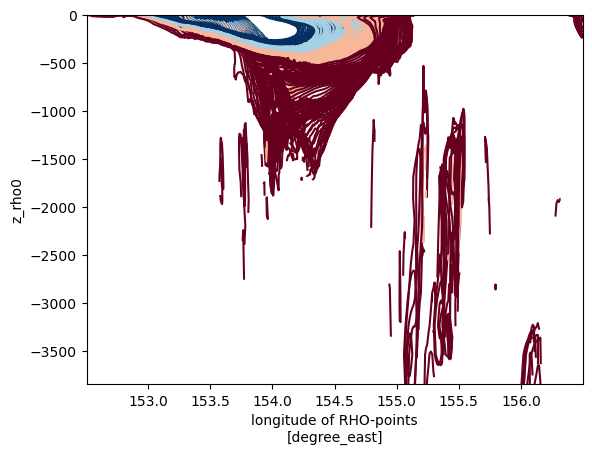

In [6]:
eac_contour2=pd.DataFrame(columns=['eta_index','lon','centre_depth','max_depth','area'])

for eta_ind in range(5,595,5):
    
    
    cs=xr.plot.contour(ds.v_northward.isel(eta_rho=eta_ind,xi_rho=slice(100,500)).mean(dim="ocean_time"),x="lon_rho",y="z_rho0",levels=np.arange(-0.2,-0.05,0.05))

    coords=cs.allsegs[0][0]
    
    x,y=Polygon(coords).exterior.xy

    row_to_append=pd.DataFrame([{'eta_index':eta_ind,'lon': pd.to_numeric(Polygon(coords).centroid.xy[0]),
                                 'centre_depth':pd.to_numeric(Polygon(coords).centroid.xy[1]),'max_depth':min(y),'area':PolyArea(x,y,eta_ind)}])
    eac_contour2=pd.concat([eac_contour2,row_to_append])


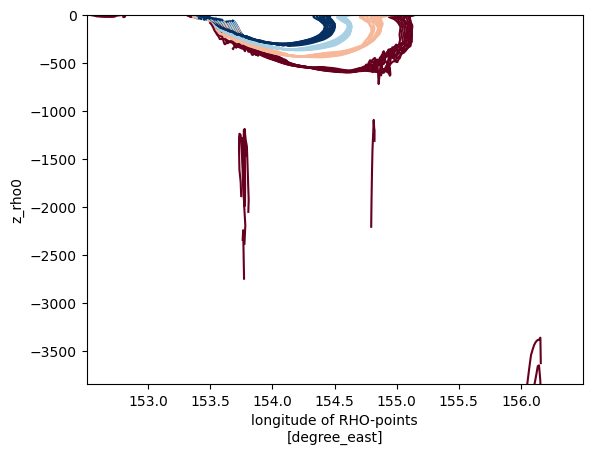

In [7]:
eac_contour2=eac_contour2[eac_contour2['max_depth']<-100]

for eta_ind in range(470,525,5):
    
    
    cs=xr.plot.contour(ds.v_northward.isel(eta_rho=eta_ind,xi_rho=slice(100,500)).mean(dim="ocean_time"),x="lon_rho",y="z_rho0",levels=np.arange(-0.2,-0.05,0.05))

    coords=np.concatenate((cs.allsegs[0][0],cs.allsegs[0][1]))
    #coords=cs.allsegs[0][0]
    x,y=Polygon(coords).exterior.xy


    row_to_append=pd.DataFrame([{'eta_index':eta_ind,'lon': pd.to_numeric(Polygon(coords).centroid.xy[0]),
                                 'centre_depth':pd.to_numeric(Polygon(coords).centroid.xy[1]),'max_depth':min(y),'area':PolyArea(x,y,eta_ind)}])
    eac_contour2=pd.concat([eac_contour2,row_to_append])



Text(0.5, 0, 'cross-sectional area (km^2)')

<Figure size 640x480 with 0 Axes>

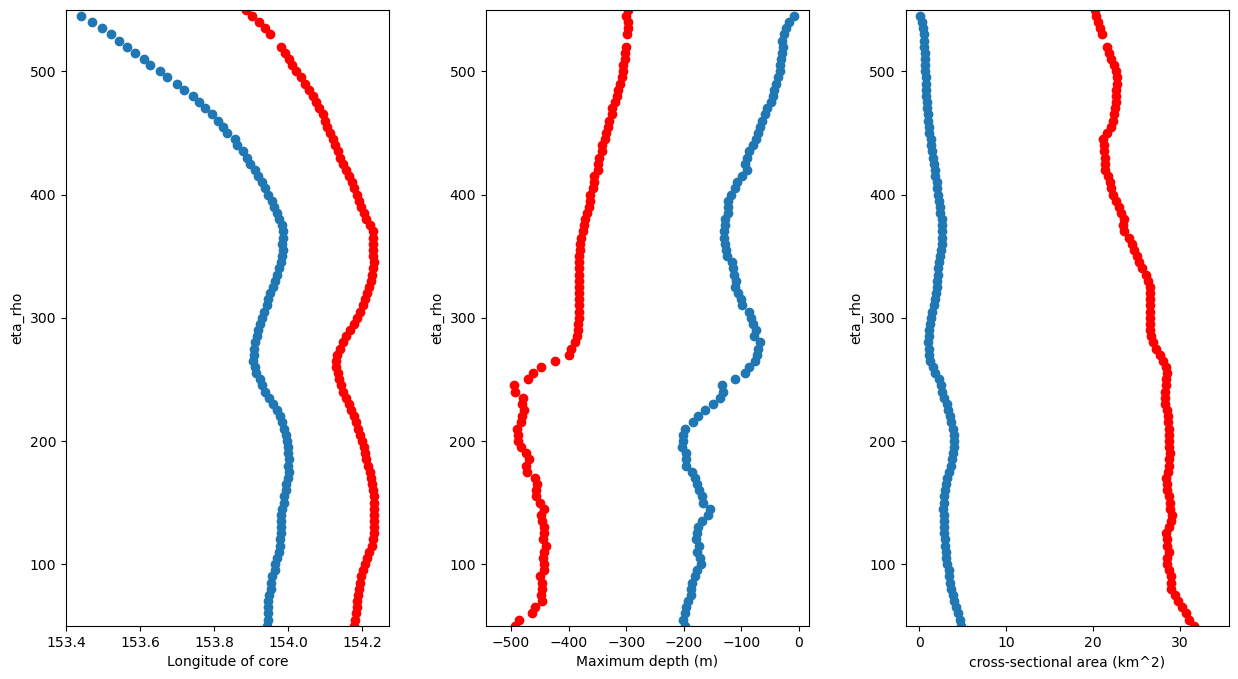

In [8]:
data=eac_contour
gs = gridspec.GridSpec(nrows=1,ncols=3,wspace=0.3, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,8])#what is this?
ax = None

ax = fig.add_subplot(gs[0,0])
plt.scatter(data.lon,data.eta_index)
plt.scatter(eac_contour2.lon,eac_contour2.eta_index,color="red")
plt.ylim(50,550)
plt.ylabel("eta_rho")
plt.xlabel("Longitude of core")

ax = fig.add_subplot(gs[0,1])
plt.scatter(data.max_depth,data.eta_index)
plt.scatter(eac_contour2.max_depth,eac_contour2.eta_index,color="red")
plt.ylim(50,550)
plt.ylabel("eta_rho")
plt.xlabel("Maximum depth (m)")

ax = fig.add_subplot(gs[0,2])
plt.scatter(data.area,data.eta_index)
plt.scatter(eac_contour2.area,eac_contour2.eta_index,color="red")
plt.ylim(50,550)
plt.ylabel("eta_rho")
plt.xlabel("cross-sectional area (km^2)")

In [9]:
lats=ds.lat_rho[:,1].to_dataframe()
lats

,lat_rho,lon_rho,lat_rho
eta_rho,,,
0,-29.995,151.515,-29.995
1,-29.985,151.515,-29.985
2,-29.975,151.515,-29.975
3,-29.965,151.515,-29.965
4,-29.955,151.515,-29.955
...,...,...,...
595,-24.045,151.515,-24.045
596,-24.035,151.515,-24.035
597,-24.025,151.515,-24.025


In [11]:
eac_contour2=eac_contour2.set_index(eac_contour2.eta_index)
eac_double=eac_contour.set_index(eac_contour.eta_index).merge(eac_contour2,how='outer',right_index=True,left_index=True)
eac_double

,eta_index_x,lon_x,centre_depth_x,max_depth_x,area_x,eta_index_y,lon_y,centre_depth_y,max_depth_y,area_y
eta_index,,,,,,,,,,
5,5,[153.90181877951872],[-93.6072633688981],-217.588136,6.111479,5,[154.09134010396534],[-205.19400144398875],-518.217646,33.776072
10,10,[153.89932795244385],[-92.76191176745603],-213.227977,6.140133,10,[154.10507836118143],[-206.98337907080446],-509.514142,33.928324
15,15,[153.90592450740365],[-92.68432546788878],-219.559104,6.054983,15,[154.1197736531894],[-206.41617001150829],-500.880352,33.931600
20,20,[153.9120251852887],[-90.94735576679038],-214.908765,5.858343,20,[154.1332338166211],[-205.05023773090866],-495.427946,33.830104
25,25,[153.92101652987571],[-89.5152465218353],-211.965967,5.695247,25,[154.14528573191666],[-203.00244080953485],-495.116674,33.611380
...,...,...,...,...,...,...,...,...,...,...
570,NaN,NaN,NaN,NaN,NaN,570,[153.82294183501315],[-117.27778642901829],-291.355988,18.804591
575,NaN,NaN,NaN,NaN,NaN,575,[153.80329886717567],[-113.87642161875921],-286.373544,18.284049
580,NaN,NaN,NaN,NaN,NaN,580,[153.78657190040934],[-110.34167971704738],-277.919667,17.644719


In [12]:
#eac_double=eac_contour
data=eac_double.set_index(eac_double.eta_index_y).merge(lats,how='outer',right_index=True,left_index=True)
data=data.iloc[:,[1,2,3,4,5,6,7,8,9,10,11]]
#data=data.iloc[:,[0,1,2,3,4,5]]
data

,lon_x,centre_depth_x,max_depth_x,area_x,eta_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho,lon_rho
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.995,151.515
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.985,151.515
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.975,151.515
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.965,151.515
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.955,151.515
...,...,...,...,...,...,...,...,...,...,...,...
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.055,151.515
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.045,151.515
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.035,151.515
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.025,151.515


,Coast_lon,Coast_lat
0,153.519711,-29.995000
1,153.525000,-29.989485
2,153.529262,-29.985000
3,153.533775,-29.975000
4,153.535000,-29.973345
...,...,...
832,152.727686,-24.025000
833,152.725000,-24.022283
834,152.717980,-24.015000
835,152.715000,-24.011792


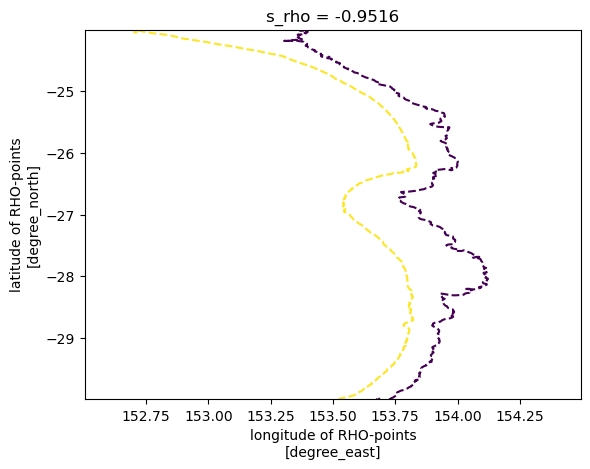

In [14]:

cs=xr.plot.contour(ds.z_rho0.isel(xi_rho=slice(100,300),s_rho=1),x="lon_rho",y="lat_rho",levels=[-1000,-100])
#for 1000m [0][1]
#for100m [1][0]
coords=cs.allsegs[1][0]

Coastline=pd.DataFrame(coords, columns=['Coast_lon', 'Coast_lat'])
Coastline

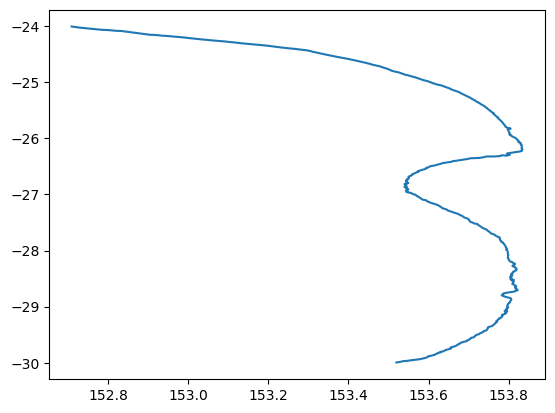

In [15]:
coords=cs.allsegs[1][0]

plt.plot(coords[:,0],coords[:,1])

In [16]:
data=data.merge(Coastline,how='left',left_on="lat_rho",right_on="Coast_lat")
data

,lon_x,centre_depth_x,max_depth_x,area_x,eta_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho,lon_rho,Coast_lon,Coast_lat
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.995,151.515,153.519711,-29.995
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.985,151.515,153.529262,-29.985
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.975,151.515,153.533775,-29.975
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.965,151.515,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.955,151.515,153.557242,-29.955
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.055,151.515,NaN,NaN
598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.045,151.515,152.752606,-24.045
599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.035,151.515,152.739155,-24.035
600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.025,151.515,152.727686,-24.025


In [17]:
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d
    

In [18]:
data['dist_x']=np.NAN
data['dist_y']=np.NAN
data

,lon_x,centre_depth_x,max_depth_x,area_x,eta_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho,lon_rho,Coast_lon,Coast_lat,dist_x,dist_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.995,151.515,153.519711,-29.995,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.985,151.515,153.529262,-29.985,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.975,151.515,153.533775,-29.975,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.965,151.515,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.955,151.515,153.557242,-29.955,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.055,151.515,NaN,NaN,NaN,NaN
598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.045,151.515,152.752606,-24.045,NaN,NaN
599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.035,151.515,152.739155,-24.035,NaN,NaN
600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.025,151.515,152.727686,-24.025,NaN,NaN


In [19]:
for i in range(len(data)):
    data['dist_y'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_y[i]))

for i in range(len(data)):
    data['dist_x'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_x[i]))


/tmp/ipykernel_1040976/3301919446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist_y'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_y[i]))
/tmp/ipykernel_1040976/3301919446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist_y'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_y[i]))
/tmp/ipykernel_1040976/3301919446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Text(0.01, 0.99, 'd')

<Figure size 640x480 with 0 Axes>

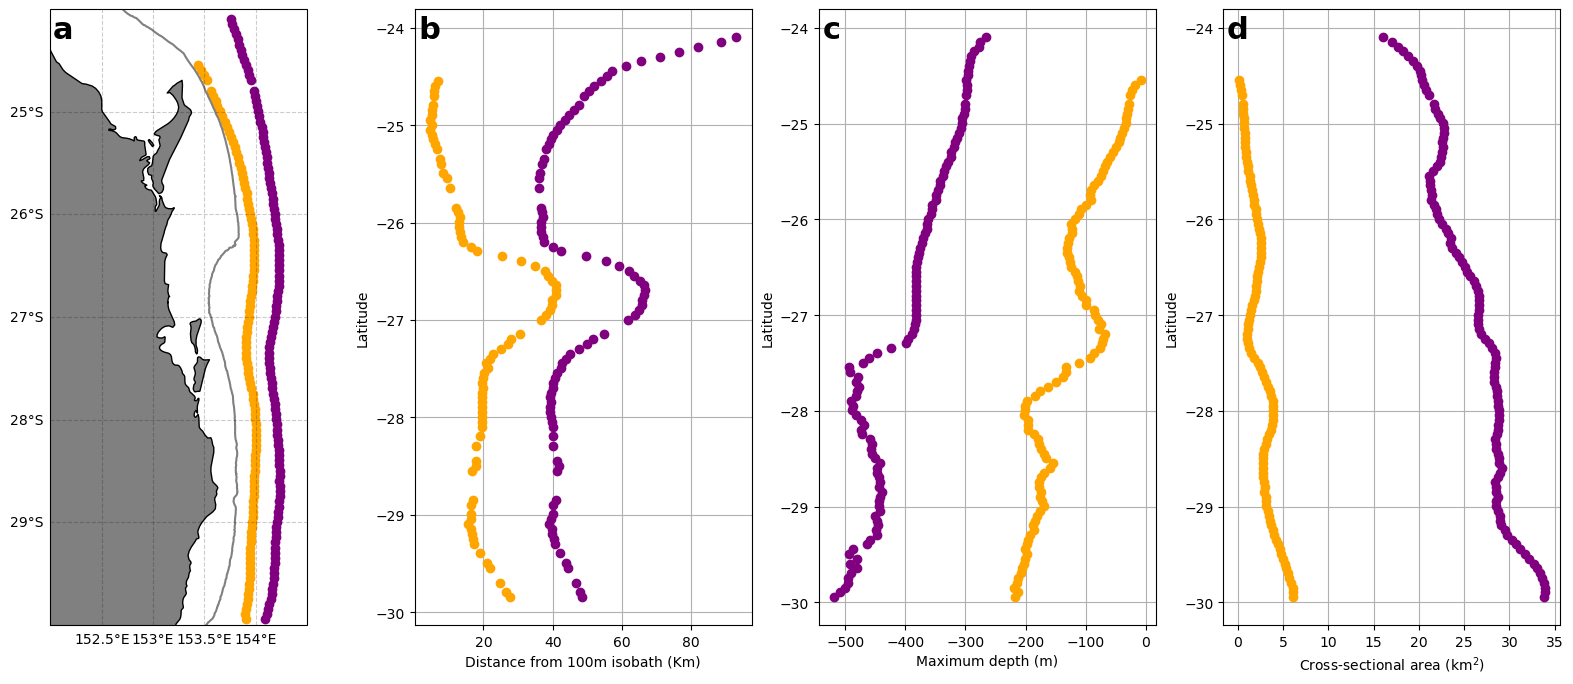

In [20]:

gs = gridspec.GridSpec(nrows=1,ncols=4,wspace=0.2, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([152, 154.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
plt.scatter(data.lon_x,data.lat_rho,color="orange")
plt.scatter(data.lon_y,data.lat_rho,color='purple')
gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
plt.plot(Coastline.Coast_lon,Coastline.Coast_lat,c="grey")
#axis labels
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True
ax.set_title('')
plt.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.dist_x,data.lat_rho,color="orange")
plt.scatter(data.dist_y,data.lat_rho,color="purple")
#plt.xlim(47,49)
plt.ylabel("Latitude")
plt.xlabel("Distance from 100m isobath (Km)")
plt.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.max_depth_x,data.lat_rho,color="orange")
plt.scatter(data.max_depth_y,data.lat_rho,color="purple")
plt.ylabel("Latitude")
plt.xlabel("Maximum depth (m)")
plt.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,3])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.area_x,data.lat_rho,color="orange")
plt.scatter(data.area_y,data.lat_rho,color="purple")
plt.ylabel("Latitude")
plt.xlabel("Cross-sectional area (km$^2$)")
plt.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

Correlate with things

In [22]:
def convert_to_float(arr):
    return arr[0] if isinstance(arr, np.ndarray) else arr

# Apply the function to the 'longitudes' column
data['lon']=data['lon_x'].apply(convert_to_float)

#add max depth
# Create masks for latitude and longitude (PROBLEM WITH MASKS)
lat_mask = ds['lat_rho'].isin(data['lat_rho'])
lon_mask = ds['lon_rho'].isin(data['lon'])

# Combine masks to get a final mask
final_mask = lat_mask & lon_mask
df_selected_data = ds['z_rho0'].min(dim='s_rho').where(final_mask).to_dataframe()

df_merged = pd.concat([data, df_selected_data], axis=1)

#add shelf width


#add wind stress (ASSUME FOLLOW METHOD OF MAX DEPTH, will need to load in origional ds)

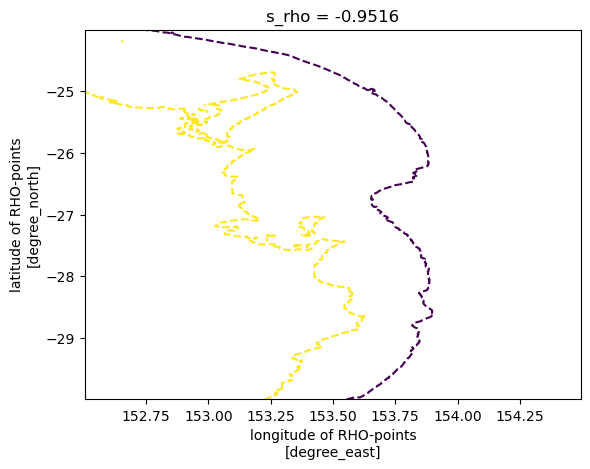

In [24]:
cs=xr.plot.contour(ds.z_rho0.isel(xi_rho=slice(100,300),s_rho=1),x="lon_rho",y="lat_rho",levels=[-200,-1])

coords0=cs.allsegs[1][0]
coords200=cs.allsegs[0][0]

shelf_lats=pd.DataFrame(coords0,columns=['Coast_lon', 'Coast_lat']).merge(pd.DataFrame(coords200,columns=['Edge_lon', 'Edge_lat']),how="outer",left_on="Coast_lat",right_on="Edge_lat")


In [25]:

shelf_lats['width']=np.NAN

for i in range(len(data)):
    shelf_lats['width'][i]=distance((shelf_lats.Coast_lat[i],shelf_lats.Coast_lon[i]),(shelf_lats.Edge_lat[i],shelf_lats.Edge_lon[i]))


Reapeat for temporal variability (manually)

In [3]:
def PolyArea(x,y,eta_ind):
    dx= x*np.asarray((111132.954 * np.cos((math.pi/180*ds.lat_rho.isel(eta_rho=eta_ind)[1].values))))
    return 0.5*np.abs(np.dot(dx,np.roll(y,1))-np.dot(y,np.roll(dx,1)))*1e-6

eac_contour=pd.DataFrame(columns=['time_index','lon','centre_depth','max_depth','area'])

eta_ind=100


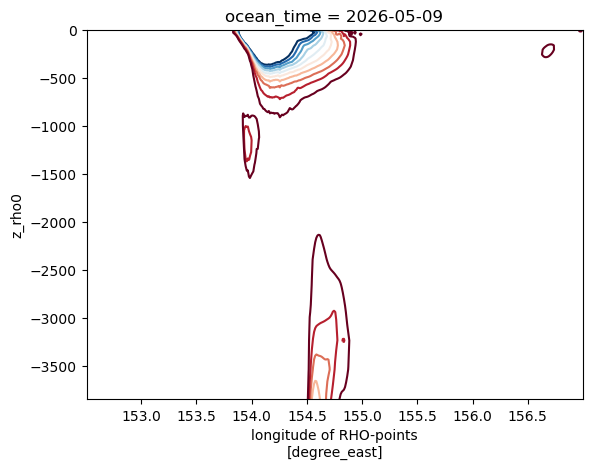

In [78]:
time_ind=26
cs=xr.plot.contour(ds.v_northward.isel(eta_rho=eta_ind,xi_rho=slice(100,550),ocean_time=time_ind),x="lon_rho",y="z_rho0",levels=np.arange(-0.6,-0.1,0.05))
 

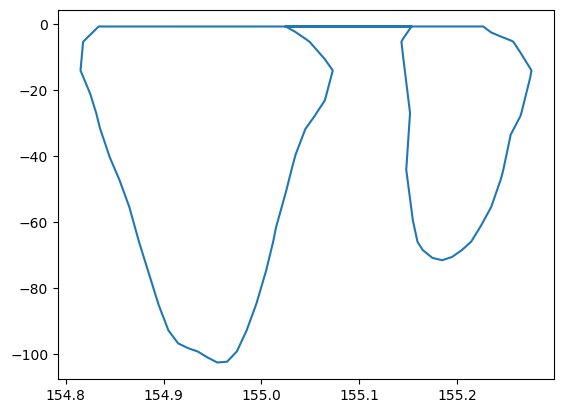

In [75]:
#coords=cs.allsegs[0][1]
coords=np.concatenate((cs.allsegs[0][0],cs.allsegs[0][1]))
    
x,y=Polygon(coords).exterior.xy
plt.plot(x,y)



In [242]:
row_to_append=pd.DataFrame([{'time_index':time_ind,'lon': pd.to_numeric(Polygon(coords).centroid.xy[0]),
                              'centre_depth':pd.to_numeric(Polygon(coords).centroid.xy[1]),'max_depth':min(y),'area':PolyArea(x,y,eta_ind)}])
eac_contour=pd.concat([eac_contour,row_to_append])

In [366]:
#for speed is 0.2
#0,0,1,1,3,1,1,[0,1],[0,1],0,2,1,1,1,0,0,1,1,1,1,1,1,2,1,2,0,1,1,0,1,1,0,0,0,[0,1],0,0,0,1,3,1,1,3,0,1,0,0,[0,1],[0,3],1,1,0,[0,1],0,0,0,1,1,2,1,1,1,0,0,[0,3],0,2,1,1,[0,3],0,0,[0,1]
eac_contour

#for speed is 0.6
#0,0,0,0,0,0,0,0,0,NA,NA, NA, 0, 0,0,0,0,0,0,NA,0,NA,0,0,0,0,0,0,0,0,NA,0,0,0,1,NA,NA,NA,NA,NA,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

,time_index,lon,centre_depth,max_depth,area
0,0,[154.33999504625447],[-296.17333354974346],-785.721867,54.452826
0,1,[154.23739918046306],[-238.65337029482768],-596.999749,36.977258
0,2,[154.16808025022883],[-208.60033483544606],-520.556476,27.547692
0,3,[154.25706699539347],[-196.6524844487958],-449.982639,22.737474
0,4,[154.47655912073208],[-197.40318881412392],-480.778503,26.763710
...,...,...,...,...,...
0,68,[154.4236532260931],[-331.0574737440631],-977.483779,82.541725
0,69,[154.41678851414673],[-323.0287302302901],-836.902996,76.572824
0,70,[154.35809210747098],[-340.7001085669418],-894.831478,68.627878
0,71,[154.3099976769725],[-361.0449770633814],-913.987277,59.032700


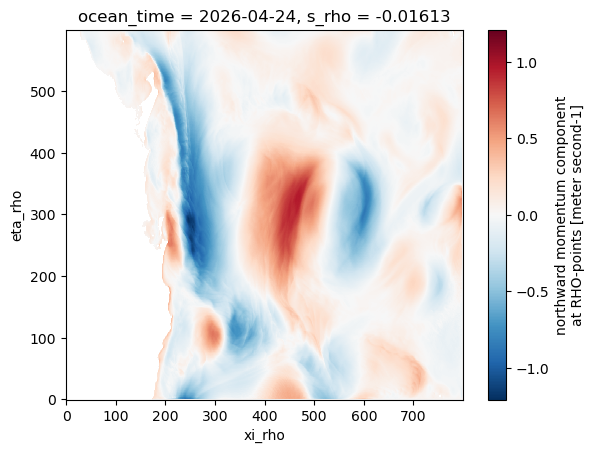

In [74]:
ds.v_northward.isel(s_rho=-1,ocean_time=time_ind).plot()

In [245]:
eac_contour.to_csv("/seq001/data/EAC_at29_06ms.csv")

Plot both EAC speeds

In [36]:
eac_contour=pd.read_csv("/seq001/data/EAC_at29_06ms.csv")
eac_contour

,Unnamed: 0,time_index,lon,centre_depth,max_depth,area
0,0,0,[154.17291278],[-154.03838868],-374.151849,19.595903
1,0,1,[154.07762225],[-134.79467185],-336.846395,12.702578
2,0,2,[154.01511183],[-127.02135692],-295.453318,6.979044
3,0,3,[154.19323879],[-48.83145273],-121.047003,2.664022
4,0,4,[154.38880607],[-102.02097076],-252.020520,8.201354
...,...,...,...,...,...,...
57,0,68,[154.11779074],[-129.30420988],-301.500772,13.905717
58,0,69,[154.12208507],[-163.53399639],-377.422119,18.380044
59,0,70,[154.19056146],[-164.57470836],-412.902948,23.681327
60,0,71,[154.17738004],[-173.76163425],-422.062042,21.437687


In [37]:
eac_contour02=pd.read_csv("/seq001/data/EAC_at29.csv")
eac_contour02

,Unnamed: 0,time_index,lon,centre_depth,max_depth,area
0,0,0,[154.33999505],[-296.17333355],-785.721867,54.452826
1,0,1,[154.23739918],[-238.65337029],-596.999749,36.977258
2,0,2,[154.16808025],[-208.60033484],-520.556476,27.547692
3,0,3,[154.257067],[-196.65248445],-449.982639,22.737474
4,0,4,[154.47655912],[-197.40318881],-480.778503,26.763710
...,...,...,...,...,...,...
68,0,68,[154.42365323],[-331.05747374],-977.483779,82.541725
69,0,69,[154.41678851],[-323.02873023],-836.902996,76.572824
70,0,70,[154.35809211],[-340.70010857],-894.831478,68.627878
71,0,71,[154.30999768],[-361.04497706],-913.987277,59.032700


In [38]:
#merge
eac_contour02=eac_contour02.set_index(eac_contour02.time_index)
eac_double=eac_contour.set_index(eac_contour.time_index).merge(eac_contour02,how='outer',right_index=True,left_index=True)
eac_double

,Unnamed: 0_x,time_index_x,lon_x,centre_depth_x,max_depth_x,area_x,Unnamed: 0_y,time_index_y,lon_y,centre_depth_y,max_depth_y,area_y
time_index,,,,,,,,,,,,
0,0.0,0.0,[154.17291278],[-154.03838868],-374.151849,19.595903,0,0,[154.33999505],[-296.17333355],-785.721867,54.452826
1,0.0,1.0,[154.07762225],[-134.79467185],-336.846395,12.702578,0,1,[154.23739918],[-238.65337029],-596.999749,36.977258
2,0.0,2.0,[154.01511183],[-127.02135692],-295.453318,6.979044,0,2,[154.16808025],[-208.60033484],-520.556476,27.547692
3,0.0,3.0,[154.19323879],[-48.83145273],-121.047003,2.664022,0,3,[154.257067],[-196.65248445],-449.982639,22.737474
4,0.0,4.0,[154.38880607],[-102.02097076],-252.020520,8.201354,0,4,[154.47655912],[-197.40318881],-480.778503,26.763710
...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,68.0,[154.11779074],[-129.30420988],-301.500772,13.905717,0,68,[154.42365323],[-331.05747374],-977.483779,82.541725
69,0.0,69.0,[154.12208507],[-163.53399639],-377.422119,18.380044,0,69,[154.41678851],[-323.02873023],-836.902996,76.572824
70,0.0,70.0,[154.19056146],[-164.57470836],-412.902948,23.681327,0,70,[154.35809211],[-340.70010857],-894.831478,68.627878


In [39]:
data=eac_double

data['lat_rho']=-28.995000
data

,Unnamed: 0_x,time_index_x,lon_x,centre_depth_x,max_depth_x,area_x,Unnamed: 0_y,time_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho
time_index,,,,,,,,,,,,,
0,0.0,0.0,[154.17291278],[-154.03838868],-374.151849,19.595903,0,0,[154.33999505],[-296.17333355],-785.721867,54.452826,-28.995
1,0.0,1.0,[154.07762225],[-134.79467185],-336.846395,12.702578,0,1,[154.23739918],[-238.65337029],-596.999749,36.977258,-28.995
2,0.0,2.0,[154.01511183],[-127.02135692],-295.453318,6.979044,0,2,[154.16808025],[-208.60033484],-520.556476,27.547692,-28.995
3,0.0,3.0,[154.19323879],[-48.83145273],-121.047003,2.664022,0,3,[154.257067],[-196.65248445],-449.982639,22.737474,-28.995
4,0.0,4.0,[154.38880607],[-102.02097076],-252.020520,8.201354,0,4,[154.47655912],[-197.40318881],-480.778503,26.763710,-28.995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,68.0,[154.11779074],[-129.30420988],-301.500772,13.905717,0,68,[154.42365323],[-331.05747374],-977.483779,82.541725,-28.995
69,0.0,69.0,[154.12208507],[-163.53399639],-377.422119,18.380044,0,69,[154.41678851],[-323.02873023],-836.902996,76.572824,-28.995
70,0.0,70.0,[154.19056146],[-164.57470836],-412.902948,23.681327,0,70,[154.35809211],[-340.70010857],-894.831478,68.627878,-28.995


In [40]:
data["Coast_lat"]=-28.995
data["Coast_lon"]=153.796030
data

,Unnamed: 0_x,time_index_x,lon_x,centre_depth_x,max_depth_x,area_x,Unnamed: 0_y,time_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho,Coast_lat,Coast_lon
time_index,,,,,,,,,,,,,,,
0,0.0,0.0,[154.17291278],[-154.03838868],-374.151849,19.595903,0,0,[154.33999505],[-296.17333355],-785.721867,54.452826,-28.995,-28.995,153.79603
1,0.0,1.0,[154.07762225],[-134.79467185],-336.846395,12.702578,0,1,[154.23739918],[-238.65337029],-596.999749,36.977258,-28.995,-28.995,153.79603
2,0.0,2.0,[154.01511183],[-127.02135692],-295.453318,6.979044,0,2,[154.16808025],[-208.60033484],-520.556476,27.547692,-28.995,-28.995,153.79603
3,0.0,3.0,[154.19323879],[-48.83145273],-121.047003,2.664022,0,3,[154.257067],[-196.65248445],-449.982639,22.737474,-28.995,-28.995,153.79603
4,0.0,4.0,[154.38880607],[-102.02097076],-252.020520,8.201354,0,4,[154.47655912],[-197.40318881],-480.778503,26.763710,-28.995,-28.995,153.79603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,68.0,[154.11779074],[-129.30420988],-301.500772,13.905717,0,68,[154.42365323],[-331.05747374],-977.483779,82.541725,-28.995,-28.995,153.79603
69,0.0,69.0,[154.12208507],[-163.53399639],-377.422119,18.380044,0,69,[154.41678851],[-323.02873023],-836.902996,76.572824,-28.995,-28.995,153.79603
70,0.0,70.0,[154.19056146],[-164.57470836],-412.902948,23.681327,0,70,[154.35809211],[-340.70010857],-894.831478,68.627878,-28.995,-28.995,153.79603


In [41]:
data['lon_x']=data['lon_x'].str[1:-1].astype(float)
data['lon_y']=data['lon_y'].str[1:-1].astype(float)
data

,Unnamed: 0_x,time_index_x,lon_x,centre_depth_x,max_depth_x,area_x,Unnamed: 0_y,time_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho,Coast_lat,Coast_lon
time_index,,,,,,,,,,,,,,,
0,0.0,0.0,154.172913,[-154.03838868],-374.151849,19.595903,0,0,154.339995,[-296.17333355],-785.721867,54.452826,-28.995,-28.995,153.79603
1,0.0,1.0,154.077622,[-134.79467185],-336.846395,12.702578,0,1,154.237399,[-238.65337029],-596.999749,36.977258,-28.995,-28.995,153.79603
2,0.0,2.0,154.015112,[-127.02135692],-295.453318,6.979044,0,2,154.168080,[-208.60033484],-520.556476,27.547692,-28.995,-28.995,153.79603
3,0.0,3.0,154.193239,[-48.83145273],-121.047003,2.664022,0,3,154.257067,[-196.65248445],-449.982639,22.737474,-28.995,-28.995,153.79603
4,0.0,4.0,154.388806,[-102.02097076],-252.020520,8.201354,0,4,154.476559,[-197.40318881],-480.778503,26.763710,-28.995,-28.995,153.79603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,68.0,154.117791,[-129.30420988],-301.500772,13.905717,0,68,154.423653,[-331.05747374],-977.483779,82.541725,-28.995,-28.995,153.79603
69,0.0,69.0,154.122085,[-163.53399639],-377.422119,18.380044,0,69,154.416789,[-323.02873023],-836.902996,76.572824,-28.995,-28.995,153.79603
70,0.0,70.0,154.190561,[-164.57470836],-412.902948,23.681327,0,70,154.358092,[-340.70010857],-894.831478,68.627878,-28.995,-28.995,153.79603


In [42]:
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [43]:
data['dist_x']=np.NAN
data['dist_y']=np.NAN
data

,Unnamed: 0_x,time_index_x,lon_x,centre_depth_x,max_depth_x,area_x,Unnamed: 0_y,time_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho,Coast_lat,Coast_lon,dist_x,dist_y
time_index,,,,,,,,,,,,,,,,,
0,0.0,0.0,154.172913,[-154.03838868],-374.151849,19.595903,0,0,154.339995,[-296.17333355],-785.721867,54.452826,-28.995,-28.995,153.79603,NaN,NaN
1,0.0,1.0,154.077622,[-134.79467185],-336.846395,12.702578,0,1,154.237399,[-238.65337029],-596.999749,36.977258,-28.995,-28.995,153.79603,NaN,NaN
2,0.0,2.0,154.015112,[-127.02135692],-295.453318,6.979044,0,2,154.168080,[-208.60033484],-520.556476,27.547692,-28.995,-28.995,153.79603,NaN,NaN
3,0.0,3.0,154.193239,[-48.83145273],-121.047003,2.664022,0,3,154.257067,[-196.65248445],-449.982639,22.737474,-28.995,-28.995,153.79603,NaN,NaN
4,0.0,4.0,154.388806,[-102.02097076],-252.020520,8.201354,0,4,154.476559,[-197.40318881],-480.778503,26.763710,-28.995,-28.995,153.79603,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,68.0,154.117791,[-129.30420988],-301.500772,13.905717,0,68,154.423653,[-331.05747374],-977.483779,82.541725,-28.995,-28.995,153.79603,NaN,NaN
69,0.0,69.0,154.122085,[-163.53399639],-377.422119,18.380044,0,69,154.416789,[-323.02873023],-836.902996,76.572824,-28.995,-28.995,153.79603,NaN,NaN
70,0.0,70.0,154.190561,[-164.57470836],-412.902948,23.681327,0,70,154.358092,[-340.70010857],-894.831478,68.627878,-28.995,-28.995,153.79603,NaN,NaN


In [44]:
for i in range(len(data)):
    data['dist_y'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_y[i]))

for i in range(len(data)):
    data['dist_x'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_x[i]))

/tmp/ipykernel_8359/1933044500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist_y'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_y[i]))
/tmp/ipykernel_8359/1933044500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist_y'][i]=distance((data.Coast_lat[i],data.Coast_lon[i]),(data.lat_rho[i],data.lon_y[i]))
/tmp/ipykernel_8359/1933044500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [45]:
dates = pd.to_datetime(ds['ocean_time'].values)  # Convert the numpy array of dates to Pandas datetime objects
modified_dates = [date.replace(year=2018) for date in dates]
modified_dates[0] = [date.replace(year=2017) for date in dates][0]
ds['ocean_time'] = modified_dates

time=ds.ocean_time.to_dataframe()
time

,ocean_time
ocean_time,
2017-12-30,2017-12-30
2018-01-04,2018-01-04
2018-01-09,2018-01-09
2018-01-14,2018-01-14
2018-01-19,2018-01-19
...,...
2018-12-05,2018-12-05
2018-12-10,2018-12-10
2018-12-15,2018-12-15


In [46]:
data=pd.concat([data.reset_index(drop=True),time.reset_index(drop=True)],axis=1)
data

,Unnamed: 0_x,time_index_x,lon_x,centre_depth_x,max_depth_x,area_x,Unnamed: 0_y,time_index_y,lon_y,centre_depth_y,max_depth_y,area_y,lat_rho,Coast_lat,Coast_lon,dist_x,dist_y,ocean_time
0,0.0,0.0,154.172913,[-154.03838868],-374.151849,19.595903,0,0,154.339995,[-296.17333355],-785.721867,54.452826,-28.995,-28.995,153.79603,36.654842,52.904894,2017-12-30
1,0.0,1.0,154.077622,[-134.79467185],-336.846395,12.702578,0,1,154.237399,[-238.65337029],-596.999749,36.977258,-28.995,-28.995,153.79603,27.387086,42.926649,2018-01-04
2,0.0,2.0,154.015112,[-127.02135692],-295.453318,6.979044,0,2,154.168080,[-208.60033484],-520.556476,27.547692,-28.995,-28.995,153.79603,21.307453,36.184840,2018-01-09
3,0.0,3.0,154.193239,[-48.83145273],-121.047003,2.664022,0,3,154.257067,[-196.65248445],-449.982639,22.737474,-28.995,-28.995,153.79603,38.631706,44.839498,2018-01-14
4,0.0,4.0,154.388806,[-102.02097076],-252.020520,8.201354,0,4,154.476559,[-197.40318881],-480.778503,26.763710,-28.995,-28.995,153.79603,57.652142,66.186795,2018-01-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,68.0,154.117791,[-129.30420988],-301.500772,13.905717,0,68,154.423653,[-331.05747374],-977.483779,82.541725,-28.995,-28.995,153.79603,31.293789,61.041295,2018-12-05
69,0.0,69.0,154.122085,[-163.53399639],-377.422119,18.380044,0,69,154.416789,[-323.02873023],-836.902996,76.572824,-28.995,-28.995,153.79603,31.711447,60.373648,2018-12-10
70,0.0,70.0,154.190561,[-164.57470836],-412.902948,23.681327,0,70,154.358092,[-340.70010857],-894.831478,68.627878,-28.995,-28.995,153.79603,38.371314,54.664973,2018-12-15
71,0.0,71.0,154.177380,[-173.76163425],-422.062042,21.437687,0,71,154.309998,[-361.04497706],-913.987277,59.032700,-28.995,-28.995,153.79603,37.089318,49.987418,2018-12-20


Text(0.01, 0.99, 'd')

<Figure size 640x480 with 0 Axes>

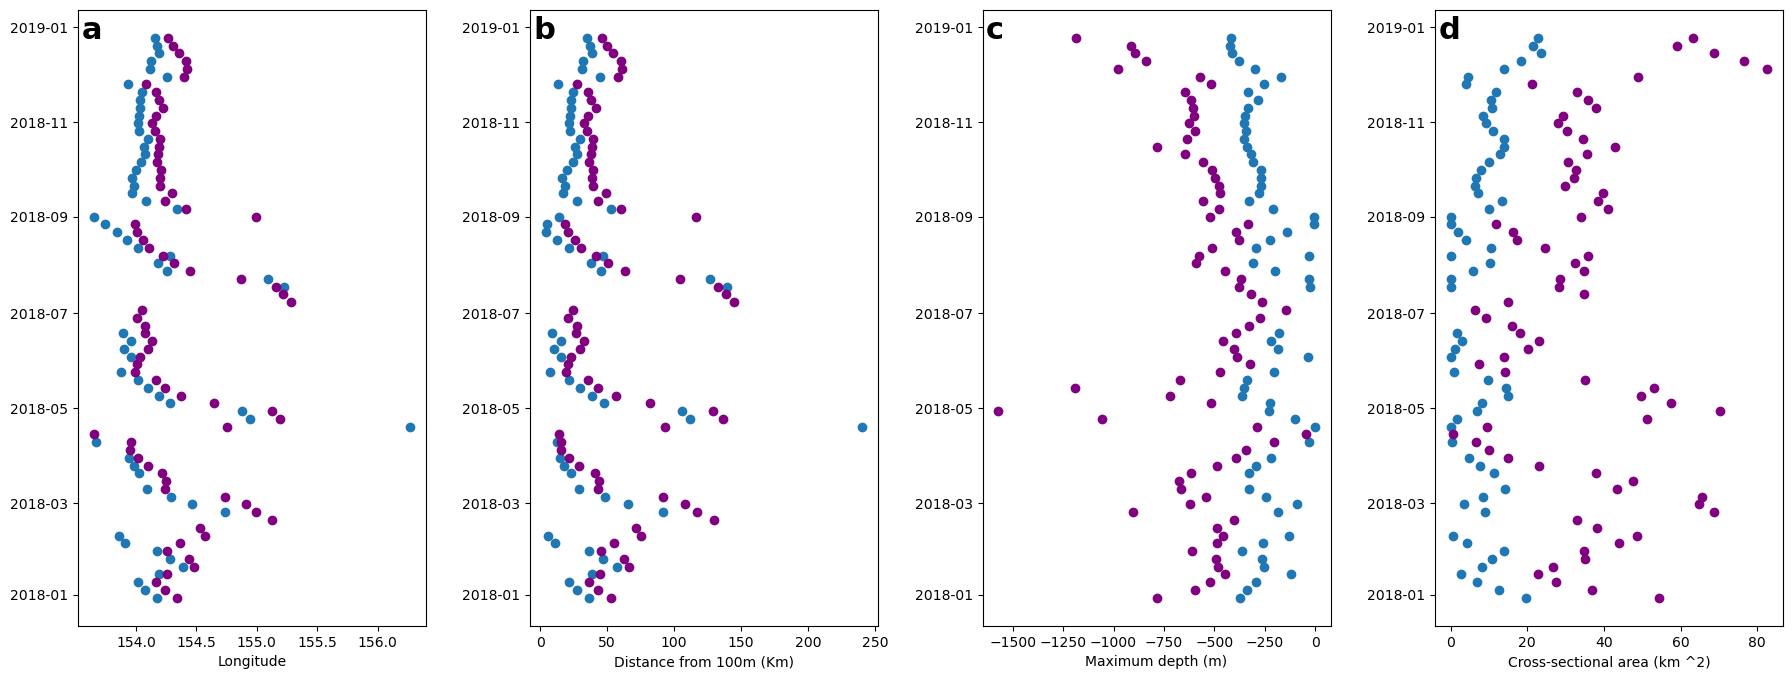

In [47]:

gs = gridspec.GridSpec(nrows=1,ncols=4,wspace=0.3, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[22,8])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0])
plt.scatter(data.lon_x,data.ocean_time)
plt.scatter(data.lon_y,data.ocean_time,color='purple')
#plt.ylabel("Date")
plt.xlabel("Longitude")
plt.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1])
plt.scatter(data.dist_x,data.ocean_time)
plt.scatter(data.dist_y,data.ocean_time,color="purple")
#plt.xlim(47,49)
#plt.ylabel("Date")
plt.xlabel("Distance from 100m (Km)")
plt.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2])
plt.scatter(data.max_depth_x,data.ocean_time)
plt.scatter(data.max_depth_y,data.ocean_time,color="purple")
#plt.ylabel("Date")
plt.xlabel("Maximum depth (m)")
plt.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,3])
plt.scatter(data.area_x,data.ocean_time)
plt.scatter(data.area_y,data.ocean_time,color="purple")
#plt.ylabel("Date")
plt.xlabel("Cross-sectional area (km ^2)")
plt.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

Text(0.01, 0.99, 'c')

<Figure size 640x480 with 0 Axes>

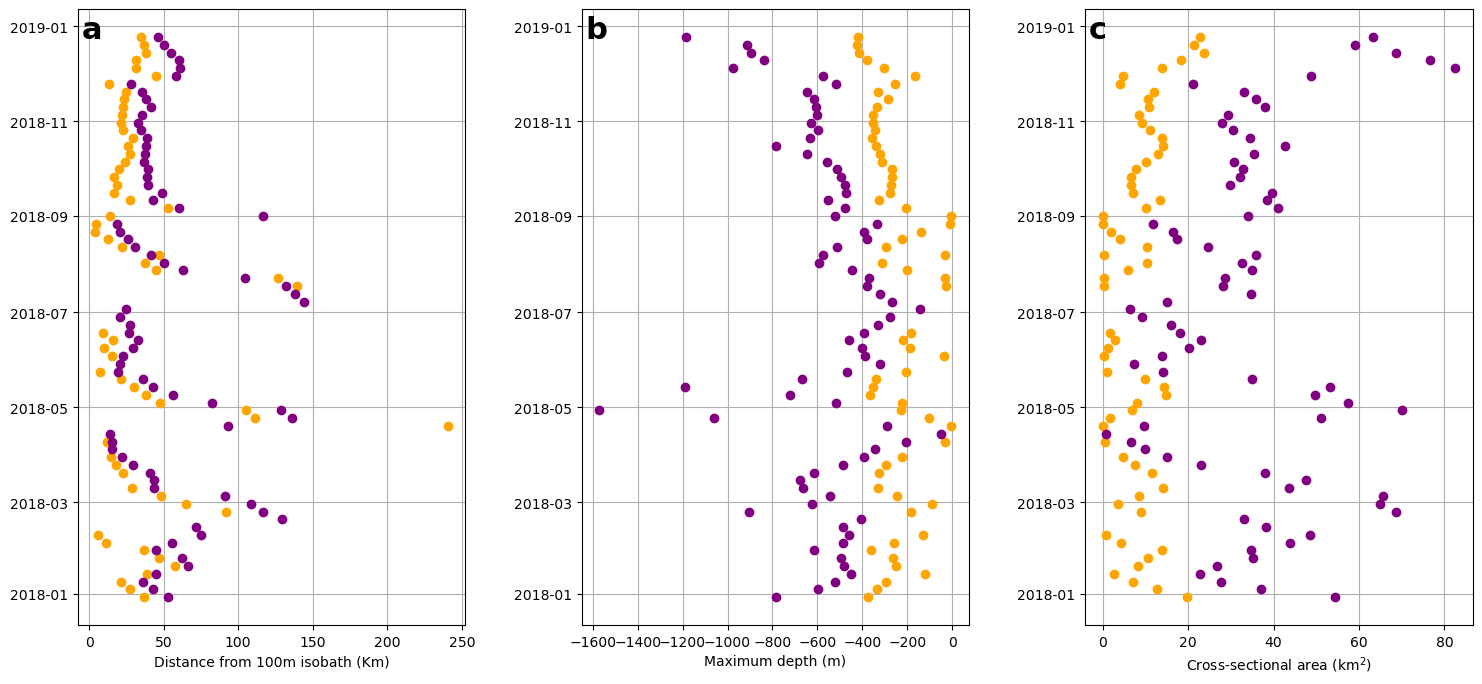

In [48]:
gs = gridspec.GridSpec(nrows=1,ncols=3,wspace=0.3, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,8])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.dist_x,data.ocean_time,color="orange")
plt.scatter(data.dist_y,data.ocean_time,color="purple")
#plt.xlim(47,49)
#plt.ylabel("Date")
plt.xlabel("Distance from 100m isobath (Km)")
plt.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.max_depth_x,data.ocean_time,color="orange")
plt.scatter(data.max_depth_y,data.ocean_time,color="purple")
#plt.ylabel("Date")
plt.xlabel("Maximum depth (m)")
plt.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.area_x,data.ocean_time,color="orange")
plt.scatter(data.area_y,data.ocean_time,color="purple")
#plt.ylabel("Date")
plt.xlabel("Cross-sectional area (km$^2$)")
plt.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')